In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn

In [6]:
df = pd.read_csv("/Users/simrantanwar/Desktop/College/DDP_phase2/New Experiments/data/metabric_before_imp.csv")
df = df.drop(['Unnamed: 0'],axis=1)

In [7]:

class DenoisingAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, noise_level=0.2):
        super().__init__()
        self.noise_level = noise_level
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, training=False):
        if training:
            noise = torch.bernoulli((1 - self.noise_level) * torch.ones_like(x))
            x = x * noise
        return self.decoder(self.encoder(x))

def masked_mse_loss(original, reconstructed, mask):
    diff = (original - reconstructed) ** 2
    masked_diff = diff * mask
    return masked_diff.sum() / mask.sum()

def train_dae(X_np, mask_np, epochs=100, lr=1e-3, hidden_dim=64, noise_level=0.05, patience=10):
    input_dim = X_np.shape[1]
    model = DenoisingAutoEncoder(input_dim, hidden_dim, noise_level)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    original = torch.tensor(X_np, dtype=torch.float32)
    mask = torch.tensor(mask_np, dtype=torch.float32)
    col_mean = np.nanmean(X_np, axis=0)
    inputs_np = np.where(np.isnan(X_np), col_mean, X_np)
    inputs = torch.tensor(inputs_np, dtype=torch.float32)

    n = inputs.shape[0]
    idx = int(n * 0.9)
    train_inp, val_inp = inputs[:idx], inputs[idx:]
    train_ori, val_ori = original[:idx], original[idx:]
    train_mask, val_mask = mask[:idx], mask[idx:]

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_inp, training=True)
        loss = masked_mse_loss(train_ori, output, train_mask)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_output = model(val_inp, training=False)
            val_loss = masked_mse_loss(val_ori, val_output, val_mask)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_model)
    return model

def impute_with_dae(model, X_np, mask_np):
    model.eval()
    with torch.no_grad():
        inputs = torch.nan_to_num(torch.tensor(X_np, dtype=torch.float32), nan=0.0)
        recon = model(inputs, training=False).numpy()
    X_imputed = X_np.copy()
    X_imputed[mask_np] = recon[mask_np]
    return X_imputed

class CorrelatedFeatureImputation:
    def __init__(self, df, target_cols, corr_threshold=0.85):
        self.df = df.copy()
        self.target_cols = target_cols
        self.corr_threshold = corr_threshold
        self.results_df = pd.DataFrame()

    def impute_categorical(self):
        features = self.df.drop(columns=self.target_cols)
        categorical_cols = features.select_dtypes(include='object').columns.tolist()
        cat_imputer = SimpleImputer(strategy='most_frequent')
        features[categorical_cols] = cat_imputer.fit_transform(features[categorical_cols])
        self.df.update(features)

    def find_correlated_groups(self):
        features = self.df.drop(columns=self.target_cols)
        numerical_cols = features.select_dtypes(include='number').columns.tolist()
        corr_matrix = features[numerical_cols].corr().abs()
        groups = []
        used = set()
        for col in corr_matrix.columns:
            if col in used:
                continue
            high_corr = corr_matrix[col][corr_matrix[col] > self.corr_threshold].index.tolist()
            if len(high_corr) > 1:
                groups.append(high_corr)
                used.update(high_corr)
        return groups

    def run_experiment(self, mask_rates=[0.1, 0.3, 0.5]):
        features = self.df.drop(columns=self.target_cols)
        numerical_cols = features.select_dtypes(include='number').columns.tolist()
        groups = self.find_correlated_groups()

        for mask_fraction in mask_rates:
            for group in groups:
                col_to_mask = random.choice(group)
                df_missing = features.copy()
                mask_idx = df_missing.sample(frac=mask_fraction).index
                true_values = df_missing.loc[mask_idx, col_to_mask].copy()
                df_missing.loc[mask_idx, col_to_mask] = np.nan

                # Impute with KNN
                knn_pipeline = make_pipeline(StandardScaler(), KNNImputer(n_neighbors=5))
                df_knn = df_missing.copy()
                df_knn[numerical_cols] = knn_pipeline.fit_transform(df_knn[numerical_cols])

                # Impute with MICE
                mice_pipeline = make_pipeline(StandardScaler(), IterativeImputer())
                df_mice = df_missing.copy()
                df_mice[numerical_cols] = mice_pipeline.fit_transform(df_mice[numerical_cols])

                # Impute with Mean
                mean_imputer = SimpleImputer(strategy='mean')
                df_mean = df_missing.copy()
                df_mean[numerical_cols] = mean_imputer.fit_transform(df_mean[numerical_cols])

                # Impute with DAE
                df_dae = df_missing.copy()
                mask_np = df_dae[numerical_cols].isna().values
                means = np.nanmean(df_dae[numerical_cols].values, axis=0)
                stds = np.nanstd(df_dae[numerical_cols].values, axis=0)
                stds[stds == 0] = 1.0
                df_filled = df_dae[numerical_cols].fillna(pd.Series(means, index=numerical_cols))
                X_scaled = (df_filled.values - means) / stds
                dae_model = train_dae(X_scaled, mask_np)
                X_imputed_scaled = impute_with_dae(dae_model, X_scaled, mask_np)
                X_imputed = X_imputed_scaled * stds + means
                df_dae[numerical_cols] = X_imputed

                # Normalize all
                scaler = StandardScaler()
                df_knn[numerical_cols] = scaler.fit_transform(df_knn[numerical_cols])
                df_mice[numerical_cols] = scaler.fit_transform(df_mice[numerical_cols])
                df_mean[numerical_cols] = scaler.fit_transform(df_mean[numerical_cols])
                df_dae[numerical_cols] = scaler.fit_transform(df_dae[numerical_cols])
                features_scaled = scaler.fit_transform(features[numerical_cols])

                true_vals_raw = features.loc[mask_idx, col_to_mask]
                valid_idx = true_vals_raw.dropna().index
                if valid_idx.empty:
                    continue

                true_vals = scaler.transform(features.loc[valid_idx, numerical_cols])[:, numerical_cols.index(col_to_mask)]
                knn_vals = df_knn.loc[valid_idx, col_to_mask].values
                mice_vals = df_mice.loc[valid_idx, col_to_mask].values
                mean_vals = df_mean.loc[valid_idx, col_to_mask].values
                dae_vals = df_dae.loc[valid_idx, col_to_mask].values

                if len(true_vals) == 0:
                    continue

                # Metrics
                results = []
                for method, pred in zip(['KNN', 'MICE', 'Mean', 'DAE'], [knn_vals, mice_vals, mean_vals, dae_vals]):
                    results.append({
                        'masked_feature': col_to_mask,
                        'mask_rate': mask_fraction,
                        'method': method,
                        'rmse': mean_squared_error(true_vals, pred, squared=False),
                        'mae': mean_absolute_error(true_vals, pred)
                    })
                self.results_df = pd.concat([self.results_df, pd.DataFrame(results)], ignore_index=True)

    def plot_results(self):
        if self.results_df.empty:
            print("No results to plot. Run the experiment first.")
            return

        fig, ax = plt.subplots(figsize=(12, 6))
        for method in self.results_df['method'].unique():
            subset = self.results_df[self.results_df['method'] == method]
            for feature in subset['masked_feature'].unique():
                sub = subset[subset['masked_feature'] == feature]
                ax.plot(sub['mask_rate'], sub['rmse'], marker='o', label=f"{method} - {feature}")

        ax.set_xlabel("Mask Rate")
        ax.set_ylabel("Normalized RMSE")
        ax.set_title("RMSE vs Mask Rate for Masked Features")
        ax.legend()
        plt.tight_layout()
        plt.show()


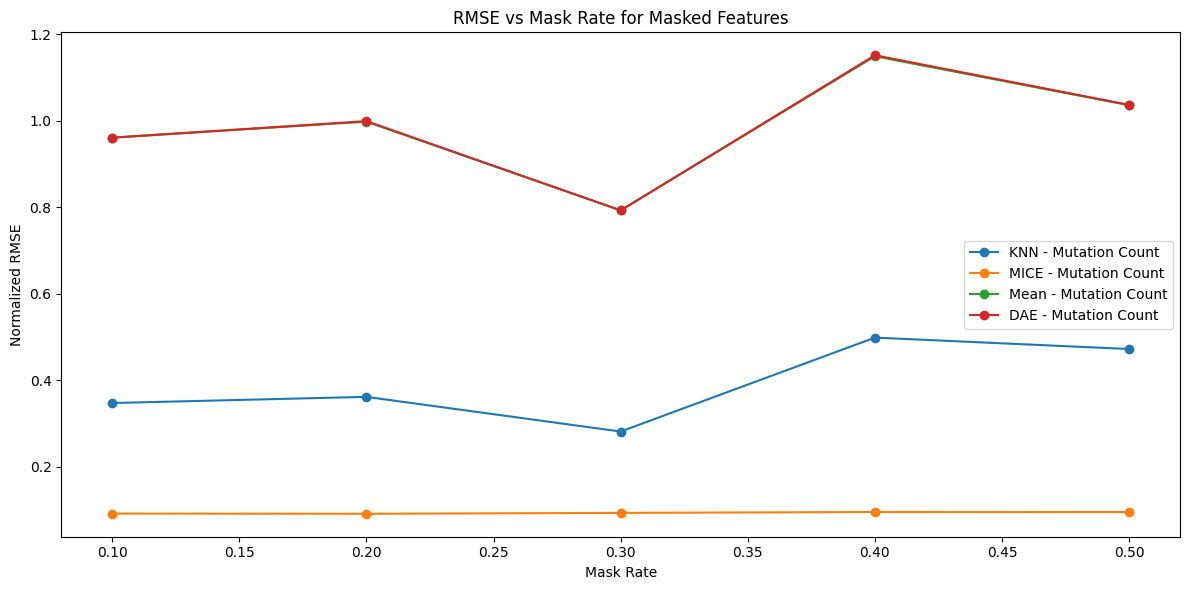

    masked_feature  mask_rate method      rmse       mae
0   Mutation Count        0.1    KNN  0.347405  0.257420
1   Mutation Count        0.1   MICE  0.091804  0.088014
2   Mutation Count        0.1   Mean  0.961155  0.689203
3   Mutation Count        0.1    DAE  0.960673  0.688473
4   Mutation Count        0.2    KNN  0.361644  0.238153
5   Mutation Count        0.2   MICE  0.091308  0.089124
6   Mutation Count        0.2   Mean  0.997857  0.656879
7   Mutation Count        0.2    DAE  0.999171  0.657639
8   Mutation Count        0.3    KNN  0.281475  0.220929
9   Mutation Count        0.3   MICE  0.093421  0.090594
10  Mutation Count        0.3   Mean  0.792848  0.609347
11  Mutation Count        0.3    DAE  0.792712  0.609282
12  Mutation Count        0.4    KNN  0.498667  0.249173
13  Mutation Count        0.4   MICE  0.095470  0.090563
14  Mutation Count        0.4   Mean  1.149087  0.688530
15  Mutation Count        0.4    DAE  1.151395  0.691320
16  Mutation Count        0.5  

In [8]:
imputer = CorrelatedFeatureImputation(df, target_cols=['OS.time', 'OS'])
imputer.impute_categorical()
imputer.run_experiment(mask_rates=[0.1,0.2, 0.3,0.4 ,0.5])
imputer.plot_results()
print(imputer.results_df)
